In [1]:
import pyTigerGraph as tg
import pandas as pd
import json 
import gradio as gr
hostName = "https://4da1bd47ec034979919364bf0615f5f4.i.tgcloud.io"
graphName = "VWG"
secret = "bqn8qgjtag3c5p3ab1s2famgc943dlqm"
userName = "user_1"
password = "A1z2e3r4*"
tigergraph_insights_map = "https://tools.tgcloud.io/insights/app/qQ9huvqsyJnD5ubjLvuzM3/page/j8AAwBUyyW6yfkhLKMYyz8/widgetShare/511QjtqrzpqiTUxr8sjiZb?domain=eaa8afeab8334e1b9f6d6b95b6216f59.i&orgName=lis-gordias&clusterid=a58dba22-5b15-4a44-be2a-c26f4c5864af&TigerGraphToken=6d7c8115-2758-4fde-8f79-5104a87e43f0"
graph = tg.TigerGraphConnection(host=hostName, graphname=graphName)

authToken = graph.getToken(secret)
authToken = authToken[0]
print(f"secret token: {authToken}")
conn = tg.TigerGraphConnection(host=hostName, graphname=graphName, username=userName, password=password, apiToken=authToken)

secret token: 23ll2nc9e4aaiuv1ic682dehok702d73


c:\Users\JulienRigot\Projets\zzEnvs\Transport\Lib\site-packages\pyTigerGraph\pyTigerGraphBase.py:105: DeprecationWarning: The `apiToken` parameter is deprecated; use `getToken()` function instead.
  warnings.warn(


# Create graph

https://docs.tigergraph.com/pytigergraph/current/object_oriented_schema/schema-def

In [27]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading
def read_csv_path(input_file):
    df = pd.read_csv(input_file.name)
    target_column = sorted(list(df.columns))
    return  gr.Dropdown(choices = target_column) , gr.Dropdown(choices = target_column) , gr.Dropdown(choices = target_column)

# Helper functions
def path_taken(results):
    edges = results[2]['@@display_edge_set']
    node_initial = None
    edge_to_ids = {edge['to_id'] for edge in edges}
    for edge in edges:
        if edge['from_id'] not in edge_to_ids:
            node_initial = edge['from_id']
            break
    if node_initial is None:
        raise ValueError("initial node cannot be determined.")
    current_node = node_initial
    path = [current_node]
    while True:
        next_node = None
        for edge in edges:
            if edge['from_id'] == current_node:
                next_node = edge['to_id']
                break
        if next_node is None:
            break
        path.append(next_node)
        current_node = next_node
    nodes = {node_name: node_name for node_name in path}
    ordered_nodes = [nodes[node_name] for node_name in path]
    return ordered_nodes

def add_or_update_final_nodes_batch(nodes_batch_full, nodes_batch , charge):
    existing_cities = [city for city, _ in nodes_batch_full]
    for node, _ in nodes_batch:
        if node in existing_cities:
            # search if town already in nodes_batch_full
            for i, (city, stock) in enumerate(nodes_batch_full):
                if city == node:
                    # update stock
                    if i == 0:
                        nodes_batch_full[i] = (city, {"Stock": nodes_batch_full[i][1]["Stock"] - charge})
                    else:
                        nodes_batch_full[i] = (city, {"Stock": nodes_batch_full[i][1]["Stock"] + charge})
            continue
        else:
            # Ajout de nouvelles entrées dans nodes_batch_full
            nodes_batch_full.extend([
                (nodes_batch[0][0], {"Stock": nodes_batch[0][1]["Stock"]}),
                (nodes_batch[1][0], {"Stock": nodes_batch[1][1]["Stock"]})
            ])
            return nodes_batch_full
    return nodes_batch_full

def add_or_update_final_edges_batch(edges_batch_full, edges_batch, charge):
    existing_edges = [(edge[0], edge[1]) for edge in edges_batch_full]
    
    for edge in edges_batch:
        # Vérifier si l'arête ou son inverse existe déjà
        if (edge[0], edge[1]) in existing_edges or (edge[1], edge[0]) in existing_edges:
            # Si l'arête existe dans l'une ou l'autre direction
            for i, (origin, destination, movement) in enumerate(edges_batch_full):
                if (origin, destination) == (edge[0], edge[1]) or (origin, destination) == (edge[1], edge[0]):
                    # Mettre à jour le mouvement pour l'arête existante
                    edges_batch_full[i] = (origin, destination, {"Daily_movement": edges_batch_full[i][2]["Daily_movement"] + charge})
            continue
        else:
            # Ajouter de nouvelles entrées à edges_batch_full
            edges_batch_full.append((edge[0], edge[1], {"Daily_movement": edge[2]["Daily_movement"]}))
    
    return edges_batch_full

# Main transfer function
def transfert_nodes_and_edges(node_initial, node_final, charge, weight_attribute="Price", nodetype="Nodes", edgetype="distribute_to"):
    global operation_count, palets_number, palets_cost, unique_origin_nodes, unique_destination_nodes, log_list, nodes_batch_full
    results = conn.runInstalledQuery("tg_astar_test", params={
        "source_vertex": node_final, "source_vertex.type": nodetype,
        "target_vertex": node_initial, "target_vertex.type": nodetype,
        "e_type_set": edgetype, "weight_type": "FLOAT",
        "latitude": "latitude", "longitude": "longitude",
        "weight_attribute": weight_attribute,
        "print_stats": "True"
    })

    order_taken = path_taken(results)
    edge_set = results[2]['@@display_edge_set']
    reordered_edges_set = []
    for location in order_taken:
        for edge in edge_set:
            if edge['from_id'] == location:
                reordered_edges_set.append(edge)

    node_set = results[2]['tmp']
    reordered_nodes_set = []
    for location in order_taken:
        for item in node_set:
            if item['v_id'] == location:
                reordered_nodes_set.append(item)

    try:
        node_i_stock = reordered_nodes_set[0]["attributes"]["Stock"]
        node_f_stock = reordered_nodes_set[-1]["attributes"]["Stock"]
        node_i_unload_capacity = reordered_nodes_set[0]["attributes"]["UnloadCapacity"]
        node_f_load_capacity = reordered_nodes_set[-1]["attributes"]["LoadCapacity"]

        if charge > node_i_stock:
            error_message = f"{node_initial} to {node_final}: Not enough stock ({charge} > {node_i_stock})"
            log_list.append(error_message)

        if charge > node_f_load_capacity:
            error_message = f"{node_initial} to {node_final}: Not enough load capacity from receiving warehouse (charge: {charge} > LoadCapacity: {node_f_load_capacity})"
            log_list.append(error_message)

        if charge > node_i_unload_capacity:
            error_message = f"{node_initial} to {node_final}: Not enough unload capacity from starting warehouse (charge: {charge} > UnloadCapacity: {node_i_unload_capacity})"
            log_list.append(error_message)

        capacity_edge = reordered_edges_set[0]["attributes"]["Capacity"]
        daily_movement = reordered_edges_set[0]["attributes"]["Daily_movement"]

        if daily_movement + charge > capacity_edge:
            error_message = f"Send {capacity_edge} from {node_initial} to {node_final}: Not enough edge capacity ({daily_movement + charge} > {capacity_edge})"
            log_list.append(error_message)

        nodes_batch = [
            (node_initial, {"Stock": node_i_stock - charge}),
            (node_final, {"Stock": node_f_stock + charge})
        ]

        edges_batch = []
        for element in reordered_edges_set:
            element['attributes']['Daily_movement'] += charge
            edges_batch.append((element["from_id"], element["to_id"], {"Daily_movement": element["attributes"]["Daily_movement"]}))
            palets_cost += element["attributes"]["Price"]

        unique_origin_nodes.add(node_initial)
        unique_destination_nodes.add(node_final)
        operation_count += 1
        palets_number += charge

        return nodes_batch , edges_batch

    except Exception as e:
        error_message = f"Error in the transfer: {e}"
        log_list.append(error_message)
        return error_message

# Thread safety
lock = threading.Lock()

def make_daily_movements(input_file, column_origin, column_destination, column_transfert):
    global operation_count, palets_number, palets_cost, unique_origin_nodes, unique_destination_nodes, log_list, nodes_batch_full
    operation_count = 0
    palets_number = 0
    palets_cost = 0
    unique_origin_nodes = set()
    unique_destination_nodes = set()
    log_list = []
    nodes_batch_full = []
    edges_batch_full = []

    df = pd.read_csv(input_file)

    def perform_transfer(row):
        try:
            origin = str(row[column_origin])
            destination = str(row[column_destination])
            volume = float(row[column_transfert])
            nodes_batch, edges_batch= transfert_nodes_and_edges(origin, destination, volume)
            with lock:
                add_or_update_final_nodes_batch(nodes_batch_full, nodes_batch, volume)
                add_or_update_final_edges_batch(edges_batch_full, edges_batch, volume )
        except Exception as e:
            log_list.append(f"Error in make_daily_movements: {e}")

    with ThreadPoolExecutor(max_workers=1000) as executor:
        futures = [executor.submit(perform_transfer, row) for index, row in df.iterrows()]
        for future in as_completed(futures):
            pass

    conn.upsertVertices("Nodes", nodes_batch_full)
    nodetype = "Nodes"
    edgetype = "distribute_to"

    conn.upsertEdges(sourceVertexType=nodetype, targetVertexType=nodetype, edgeType=edgetype, edges=edges_batch_full)

    return nodes_batch_full, edges_batch_full

nodes_batch_full, edges_batch_full = make_daily_movements(r"C:\Users\JulienRigot\OneDrive - LIS Data Solutions\Escritorio\code_GORDIAS\base de datos graph\Tigergraph\df_light_4.csv", "CODE_Origin", "CODE_Destination", "Palets")

In [21]:
nodes_batch_full, edges_batch_full = make_daily_movements(r"C:\Users\JulienRigot\OneDrive - LIS Data Solutions\Escritorio\code_GORDIAS\base de datos graph\Tigergraph\df_light_4.csv", "CODE_Origin", "CODE_Destination", "Palets")

In [22]:
print("number of nodes : " + str(len(edges_batch_full)))
nodes_batch_full, edges_batch_full

number of nodes : 8


([('Granada', {'Stock': 77.8}), ('Vigo', {'Stock': 32.2})],
 [('Granada', 'Cordoba', {'Daily_movement': 1.0}),
  ('Cordoba', 'Seville', {'Daily_movement': 1.0}),
  ('Seville', 'Madrid', {'Daily_movement': 2.0}),
  ('Madrid', 'Zaragoza', {'Daily_movement': 4.0}),
  ('Zaragoza', 'Valladolid', {'Daily_movement': 3.0}),
  ('Valladolid', 'Oviedo', {'Daily_movement': 3.0}),
  ('Oviedo', 'La Coruna', {'Daily_movement': 3.0}),
  ('La Coruna', 'Vigo', {'Daily_movement': 1.0})])

In [20]:
source = "Granada"
target = "Vigo"

In [23]:
results = conn.allPaths([("Nodes", source)], [("Nodes", target)],maxLength=len(edges_batch_full)+1)

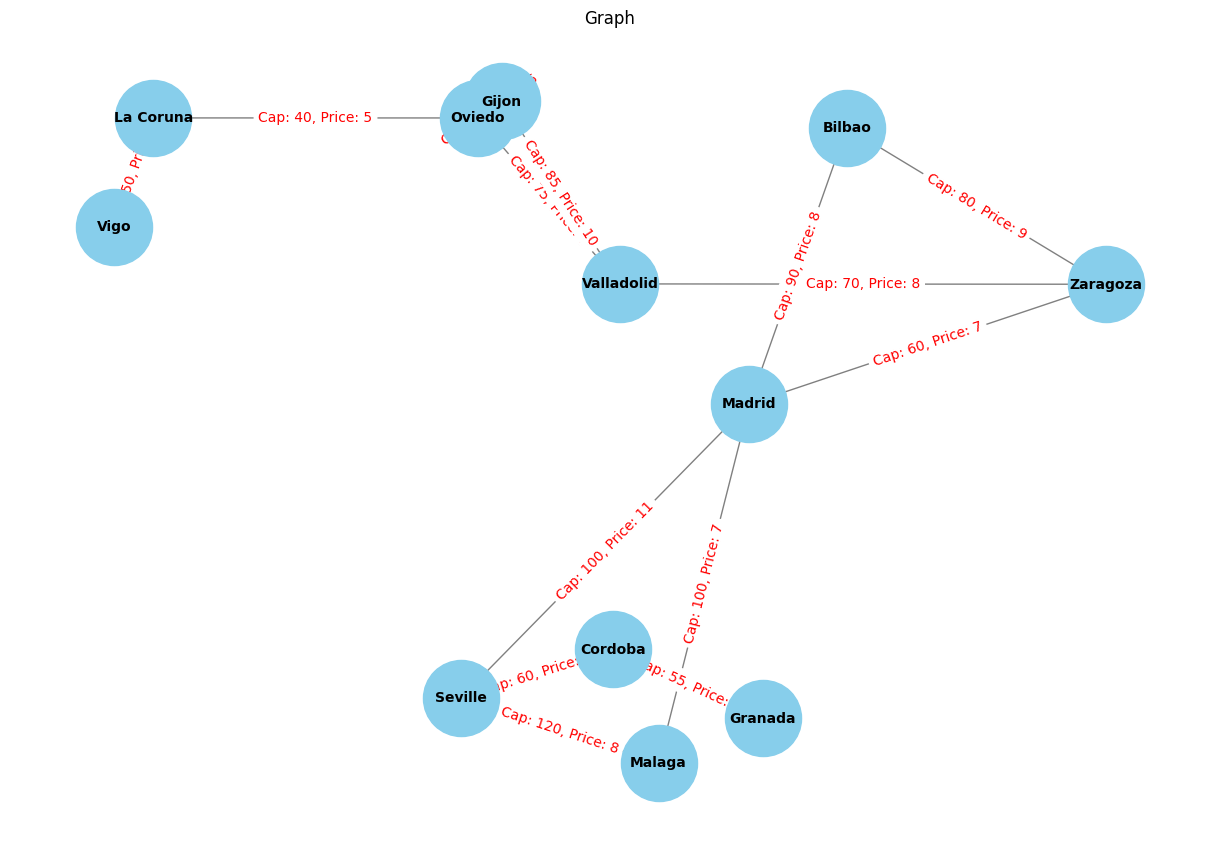

In [24]:
import networkx as nx
import matplotlib.pyplot as plt


G = nx.Graph()

# add nodes
for vertex in results[0]['vertices']:
    G.add_node(vertex['v_id'], **vertex['attributes'])

# add edges and attributes 
for edge in results[0]['edges']:
    G.add_edge(edge['from_id'], edge['to_id'], **edge['attributes'])

# position with latitude and longitude
pos = {vertex['v_id']: (vertex['attributes']['longitude'], vertex['attributes']['latitude']) for vertex in results[0]['vertices']}

# draw graph
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')

# put labels and colors
edge_labels = {(edge['from_id'], edge['to_id']): f"Cap: {edge['attributes']['Capacity']}, Price: {edge['attributes']['Price']}" for edge in results[0]['edges']}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title("Graph")
plt.show()

In [25]:
import networkx as nx

def find_two_lowest_price_paths(G, source, target, edges_batch_full):
    # Function to calculate the total price of a path
    def calculate_total_price(G, path):
        total_price = 0
        for i in range(len(path) - 1):
            edge_data = G[path[i]][path[i + 1]]
            total_price += edge_data['Price']
        return total_price

    # Find all simple paths 
    all_paths = nx.all_simple_paths(G, source, target)

    max_path_length = len(edges_batch_full) + 2

    path_prices = []

    # Iterate through all paths
    for path in all_paths:
        if len(path) <= max_path_length:
            total_price = calculate_total_price(G, path)
            path_prices.append((path, total_price))

    path_prices.sort(key=lambda x: x[1])

    top_two_paths = path_prices[:2]

    return top_two_paths

# Example usage (assuming G, source, target, and edges_batch_full are already defined)
top_paths_and_prices = find_two_lowest_price_paths(G, source, target, edges_batch_full)
print(top_paths_and_prices)

[(['Granada', 'Cordoba', 'Seville', 'Madrid', 'Zaragoza', 'Valladolid', 'Oviedo', 'La Coruna', 'Vigo'], 58), (['Granada', 'Cordoba', 'Seville', 'Malaga', 'Madrid', 'Zaragoza', 'Valladolid', 'Oviedo', 'La Coruna', 'Vigo'], 62)]


In [26]:
import networkx as nx

def find_two_lowest_price_paths(G, source, target, edges_batch_full):
    # Function to calculate the total price of a path
    def calculate_total_price(G, path):
        total_price = 0
        for i in range(len(path) - 1):
            edge_data = G[path[i]][path[i + 1]]
            total_price += edge_data['Price']
        return total_price

    # Find all simple paths from source to target
    all_paths = nx.all_simple_paths(G, source, target)

    # Define the maximum path length
    max_path_length = len(edges_batch_full) + 2

    # List to store paths and their total prices
    path_prices = []

    # Iterate through all paths and compute the total price for valid paths
    for path in all_paths:
        if len(path) <= max_path_length:
            total_price = calculate_total_price(G, path)
            path_prices.append((path, total_price))

    # Sort the list of paths by total price in ascending order
    path_prices.sort(key=lambda x: x[1])

    # Select the two paths with the lowest total prices
    top_two_paths = path_prices[:2]

    # Detailed information about nodes and edges
    proposed_paths = []
    
    for path, total_price in top_two_paths:
        nodes_info = []
        edges_info = []

        for i in range(len(path) - 1):
            from_node_id = path[i]
            to_node_id = path[i + 1]
            edge_data = G[from_node_id][to_node_id]
            price = edge_data['Price']
            edges_info.append({'e_type': 'distribute_to', 'from_id': from_node_id, 'from_type': 'Nodes',
                               'to_id': to_node_id, 'to_type': 'Nodes', 'directed': False,
                               'attributes': {'Capacity': edge_data['Capacity'], 'Price': price,
                                              'Daily_movement': edge_data['Daily_movement']}})
            from_node_attributes = G.nodes[from_node_id]
            to_node_attributes = G.nodes[to_node_id]
            nodes_info.append({'v_id': from_node_id, 'v_type': 'Nodes', 'attributes': from_node_attributes})
            nodes_info.append({'v_id': to_node_id, 'v_type': 'Nodes', 'attributes': to_node_attributes})

        proposed_paths.append({'vertices': nodes_info, 'edges': edges_info, 'total_price': total_price})

    return proposed_paths

# Example usage (assuming G, source, target, and edges_batch_full are already defined)
top_paths_and_prices = find_two_lowest_price_paths(G, source, target, edges_batch_full)
for path in top_paths_and_prices:
    print(path)

{'vertices': [{'v_id': 'Granada', 'v_type': 'Nodes', 'attributes': {'Stock': 77.8, 'Capacity': 83.9, 'LoadCapacity': 392.8, 'UnloadCapacity': 13.2, 'latitude': 37.1773, 'longitude': -3.5986}}, {'v_id': 'Cordoba', 'v_type': 'Nodes', 'attributes': {'Stock': 11.8, 'Capacity': 23.8, 'LoadCapacity': 433.1, 'UnloadCapacity': 0.9, 'latitude': 37.8882, 'longitude': -4.7794}}, {'v_id': 'Cordoba', 'v_type': 'Nodes', 'attributes': {'Stock': 11.8, 'Capacity': 23.8, 'LoadCapacity': 433.1, 'UnloadCapacity': 0.9, 'latitude': 37.8882, 'longitude': -4.7794}}, {'v_id': 'Seville', 'v_type': 'Nodes', 'attributes': {'Stock': 141.7, 'Capacity': 147.7, 'LoadCapacity': 58.2, 'UnloadCapacity': 4.9, 'latitude': 37.3886, 'longitude': -5.9823}}, {'v_id': 'Seville', 'v_type': 'Nodes', 'attributes': {'Stock': 141.7, 'Capacity': 147.7, 'LoadCapacity': 58.2, 'UnloadCapacity': 4.9, 'latitude': 37.3886, 'longitude': -5.9823}}, {'v_id': 'Madrid', 'v_type': 'Nodes', 'attributes': {'Stock': -895.4, 'Capacity': 106.9, 'Loa

In [19]:
top_paths_and_prices[1]

{'vertices': [{'v_id': 'Malaga',
   'v_type': 'Nodes',
   'attributes': {'Stock': 5.6,
    'Capacity': 19.3,
    'LoadCapacity': 472,
    'UnloadCapacity': 6.9,
    'latitude': 36.7213,
    'longitude': -4.4215}},
  {'v_id': 'Madrid',
   'v_type': 'Nodes',
   'attributes': {'Stock': -895.4,
    'Capacity': 106.9,
    'LoadCapacity': 51.4,
    'UnloadCapacity': 13.5,
    'latitude': 40.4168,
    'longitude': -3.7038}},
  {'v_id': 'Madrid',
   'v_type': 'Nodes',
   'attributes': {'Stock': -895.4,
    'Capacity': 106.9,
    'LoadCapacity': 51.4,
    'UnloadCapacity': 13.5,
    'latitude': 40.4168,
    'longitude': -3.7038}},
  {'v_id': 'Bilbao',
   'v_type': 'Nodes',
   'attributes': {'Stock': 1092.3,
    'Capacity': 98.9,
    'LoadCapacity': 216.9,
    'UnloadCapacity': 6,
    'latitude': 43.263,
    'longitude': -2.934}},
  {'v_id': 'Bilbao',
   'v_type': 'Nodes',
   'attributes': {'Stock': 1092.3,
    'Capacity': 98.9,
    'LoadCapacity': 216.9,
    'UnloadCapacity': 6,
    'latitude':